In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogFormatter, MultipleLocator
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
import numpy as np
import pycountry
from unicodedata import normalize
from datetime import datetime

#url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_confirmed  = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deadths    = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovereds = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

url_ccaa = 'https://covid19.isciii.es/resources/serie_historica_acumulados.csv'

# Adquisicion de datos

In [53]:
df_confirmed = pd.read_csv(url_confirmed)
df_deadths = pd.read_csv(url_deadths)
df_recovereds = pd.read_csv(url_recovereds)
df_ccaa = pd.read_csv(url_ccaa, skipfooter=1, encoding="iso8859_15")
#df_ccaa.groupby('CCAA Codigo ISO').head()

/Users/edavidfs/.pyenv/versions/3.7.6/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


# Casos por Comunidades Autónomas

In [54]:
display(df_ccaa.head())
df_ccaa['Fecha'] = pd.to_datetime(df_ccaa['Fecha'], format='%d/%m/%Y')

df_ccaa = df_ccaa.set_index(['CCAA Codigo ISO', 'Fecha'])
df_ccaa['Activos'] = df_ccaa['Casos ']-df_ccaa['Fallecidos']-df_ccaa['Recuperados']
display(df_ccaa.head())

,CCAA,FECHA,CASOS,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,20/2/2020,NaN,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,NaN,NaN,NaN,NaN
3,IB,20/2/2020,1.0,NaN,NaN,NaN,NaN
4,CN,20/2/2020,1.0,NaN,NaN,NaN,NaN


KeyError: 'Fecha'

In [55]:
#display(df_ccaa.head(30))
ccaa_serie = df_ccaa.index.unique(level=0).to_series()
for ccaa in ccaa_serie:
    subcode = f'ES-{ccaa}'

    if subcode == 'ES-ME':
        title = 'Melilla'
    else:
        title = pycountry.subdivisions.get(code=subcode).name
        title = title.split('/')[0]
        title_array = title.split(', ')
        if len(title_array)>1:
            title = f'{title_array[1]} {title_array[0]}'
    if title[-1] == ' ':
        title = title[:-1]
    title = title.replace('  ',' ')
    
    trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
    name_file = normalize('NFKC', normalize('NFKD', title).translate(trans_tab))
    name_file = name_file.replace(' ','-')
    
    print(title)
    fig = plt.figure(figsize=(6,10), dpi=100)

    ax = fig.add_subplot(1, 1, 1)
    df_ccaa.loc[ccaa].plot(ax=ax)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yscale('log')
    ax.set_ylim(1,50000)
    ax.grid()
    ax.set_title(title)
    ax.legend(fancybox=True, shadow=True, loc='lower left',mode="expand", bbox_to_anchor=(0., 0.92, 1., .102),
             ncol=3)
    #print(title_fig)
    fig.savefig(f'{name_file}.png')
    
    

AttributeError: 'NoneType' object has no attribute 'name'

# Funciones

In [56]:
def data_for_country(country):
    data = pd.DataFrame()
    country_confirmed_df = df_confirmed[df_confirmed['Country/Region'] == country]

    country_confirmed_df = country_confirmed_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_confirmed_df = country_confirmed_df.T
    country_confirmed_df.index = pd.to_datetime(country_confirmed_df.index)
    country_confirmed_df = pd.DataFrame(country_confirmed_df.sum(axis=1))
    # display(country_confirmed_df)
    #    display(country_confirmed_df.sum(axis=1))
    country_confirmed_df.columns = [country]
    data['Confirmados'] = country_confirmed_df[country]
    data['Confirmados_por_dia'] = country_confirmed_df[country]-country_confirmed_df[country].shift(1,fill_value=0)
    #display(country_confirmed_df[country].head())
    #display(country_confirmed_df[country].shift(1,fill_value=0).head())
    #display(data['Confirmados_por_dia'].head())
    
    country_recovereds_df = df_recovereds[df_recovereds['Country/Region'] == country]
    country_recovereds_df = country_recovereds_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_recovereds_df = country_recovereds_df.T
    country_recovereds_df.index = pd.to_datetime(country_recovereds_df.index)
    country_recovereds_df = pd.DataFrame(country_recovereds_df.sum(axis=1))
    country_recovereds_df.columns = [country]
    data = pd.concat([data, country_recovereds_df[country]], axis=1, sort=False)

    country_deadths_df = df_deadths[df_deadths['Country/Region'] == country]
    country_deadths_df = country_deadths_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_deadths_df = country_deadths_df.T
    country_deadths_df.index = pd.to_datetime(country_deadths_df.index)
    country_deadths_df = pd.DataFrame(country_deadths_df.sum(axis=1))
    country_deadths_df.columns = [country]
    data = pd.concat([data, country_deadths_df[country]], axis=1, sort=False)
    data['Muertos_por_dia'] = country_deadths_df[country]-country_deadths_df[country].shift(1, fill_value=0)
    
    data.columns = ['Confirmados', 'Confirmados_por_dia', 'Recuperados', 'Muertos','Muertos_por_dia']
    data = data.fillna(method='pad') 
    data['Activos'] = data['Confirmados'] - data['Recuperados'] - data['Muertos']

    # display(data.head())

    return data


In [57]:


spain_df = data_for_country('Spain')
italia_df = data_for_country('Italy')
china_df = data_for_country('China')
germany_df = data_for_country('Germany')
francia_df = data_for_country('France')
eeuu_df = data_for_country('US')
uk_df = data_for_country('United Kingdom')
argentina_df = data_for_country('Argentina')
peru_df =  data_for_country('Peru')
mexico_df = data_for_country('Mexico')
colombia_df = data_for_country('Colombia')
cuba_df = data_for_country('Cuba')
chile_df = data_for_country('Chile')

display(spain_df.head())
display(china_df.tail())

,Confirmados,Confirmados_por_dia,Recuperados,Muertos,Muertos_por_dia,Activos
2020-01-22,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0


,Confirmados,Confirmados_por_dia,Recuperados,Muertos,Muertos_por_dia,Activos
2020-04-10,82941,58,77791,3340,1,1810
2020-04-11,83014,73,77877,3343,3,1794
2020-04-12,83134,120,77956,3343,0,1835
2020-04-13,83213,79,78039,3345,2,1829
2020-04-14,83306,93,78200,3345,0,1761


In [58]:

def generate_info_text(country_df):
    confirmados= country_df['Confirmados'].iloc[-1]
    incremento_confirmados = confirmados-country_df['Confirmados'].iloc[-2]
    signo_confirmados = '+' if incremento_confirmados>0 else ''

    
    recuperados = country_df['Recuperados'].iloc[-1]
    incremento_recuperados = recuperados-country_df['Recuperados'].iloc[-2]
    signo_recuperados = '+' if incremento_recuperados>0 else ''

    
    muertes= country_df['Muertos'].iloc[-1]
    incremento_muertes = muertes-country_df['Muertos'].iloc[-2]
    signo_muertes = '+' if incremento_muertes>0 else ''

    
    infectados= country_df['Activos'].iloc[-1]
    incremento_infectados = infectados-country_df['Activos'].iloc[-2]
    signo_infectados = '+' if incremento_infectados>0 else ''
  
    
    fecha = country_df.index[-1]
    
    texto = f'TOTALES (AYER)\n\n'\
            f'Total Confirmados: {confirmados} ({signo_confirmados}{int(incremento_confirmados)}) \n'\
            f'Total Recuperados: {int(recuperados)} ({signo_recuperados}{int(incremento_recuperados)})\n'\
            f'Total Muertes: {int(muertes)} ({signo_muertes}{int(incremento_muertes)})\n'\
            f'Activos Actuales: {int(infectados):>6} ({signo_infectados}{int(incremento_infectados)})\n'\
            f'Actualización: {fecha.strftime("%d %b %Y")}'

    return texto


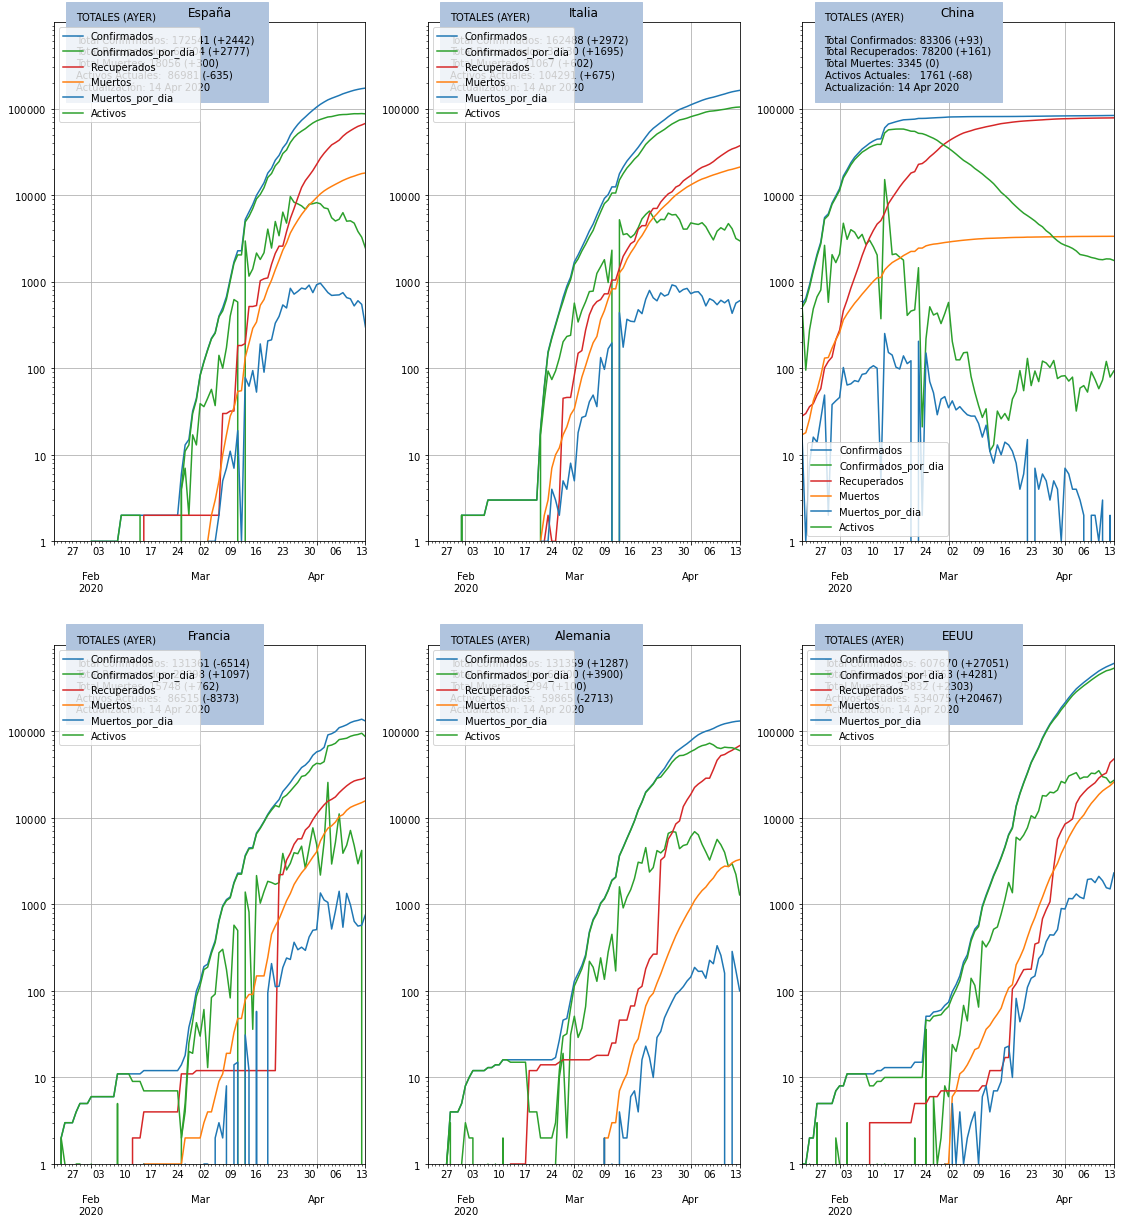

In [59]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(19, 21))
#print(axes)
titles = ['España', 'Italia', 'China', 'Francia', 'Alemania', 'EEUU', 'UK', 'Argentina', 'Peru', 'Mexico', 'Colombia','Cuba', 'Chile']
files = ['Espana', 'Italia', 'China', 'Francia', 'Alemania', 'EEUU', 'UK', 'Argentina', 'Peru', 'Mexico', 'Colombia','Cuba', 'Chile']
data = [spain_df, italia_df, china_df, francia_df, germany_df, eeuu_df, uk_df, argentina_df, peru_df,mexico_df, colombia_df, cuba_df, chile_df]

#max_y = china_df['Confirmados'].max()*10
max_y = 990000

pais_id = 0
for rox_ax in axes:
    for column_ax in rox_ax:

        data[pais_id].plot(ax=column_ax, color=['#1F77B4','#2CA02C','#D62728','#FF7F0E'])
        column_ax.set_title(titles[pais_id])
        column_ax.set_yscale('log')
        column_ax.set_ylim(1, max_y)
        column_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        column_ax.legend()
        column_ax.grid()
        column_ax.text('1/28/2020',max_y/6, generate_info_text(data[pais_id]),
                       bbox=dict(boxstyle="square",
                                 ec='lightsteelblue',
                                 facecolor='lightsteelblue',
                                 pad= 1,
                                ))
        pais_id +=1
    
fig.savefig('test.png')


# Datos por Paises

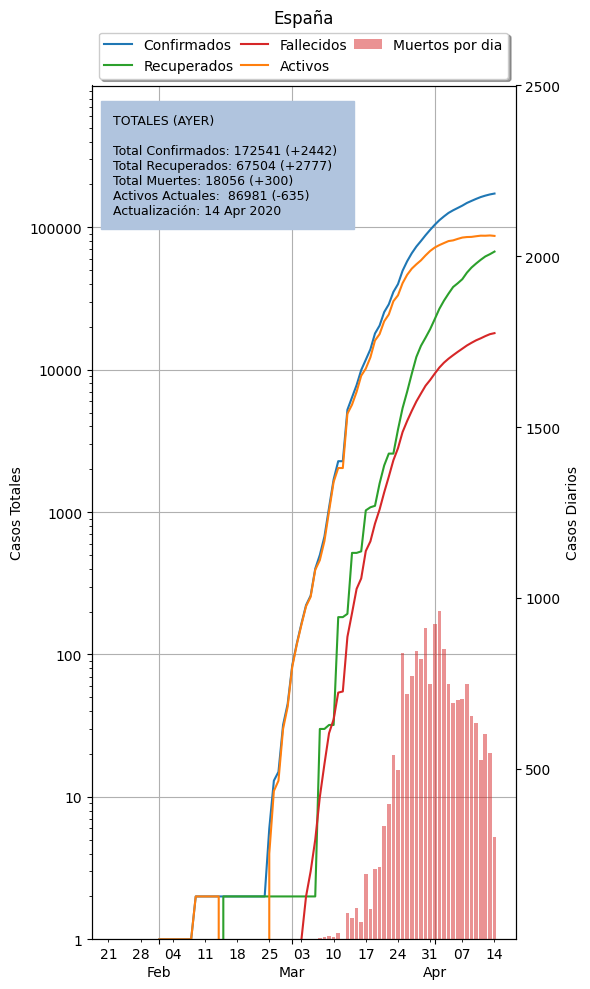

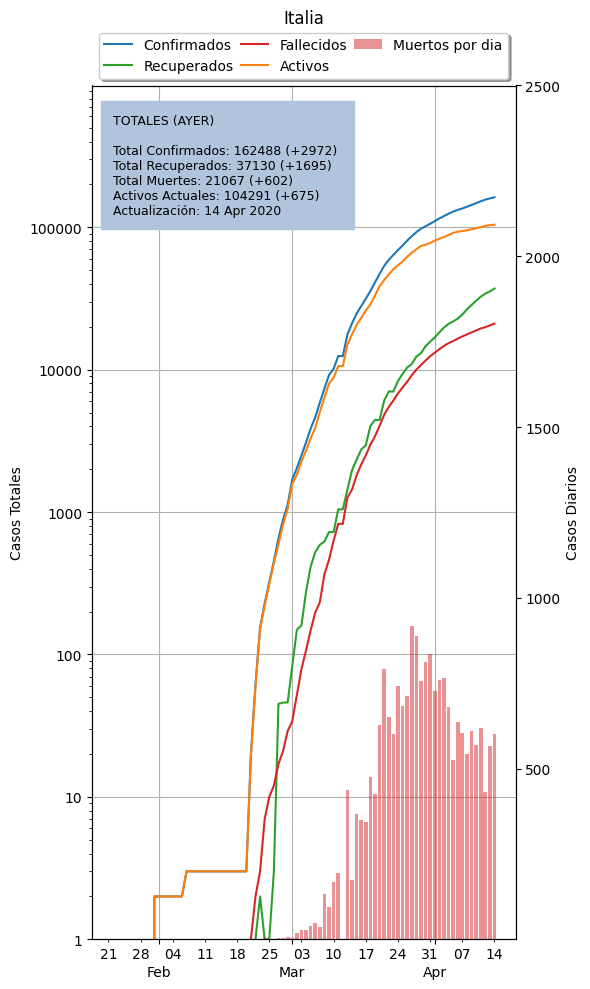

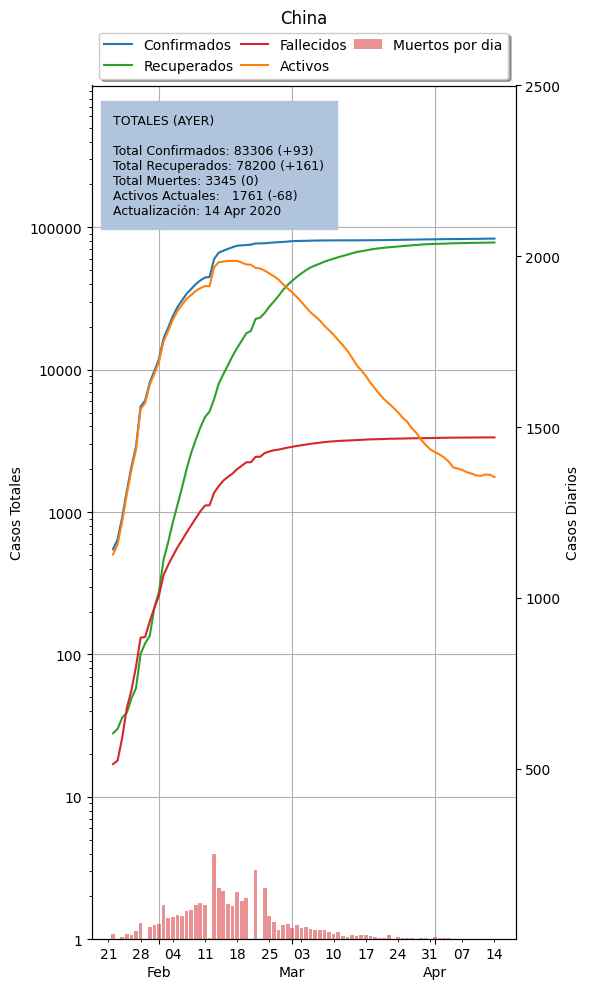

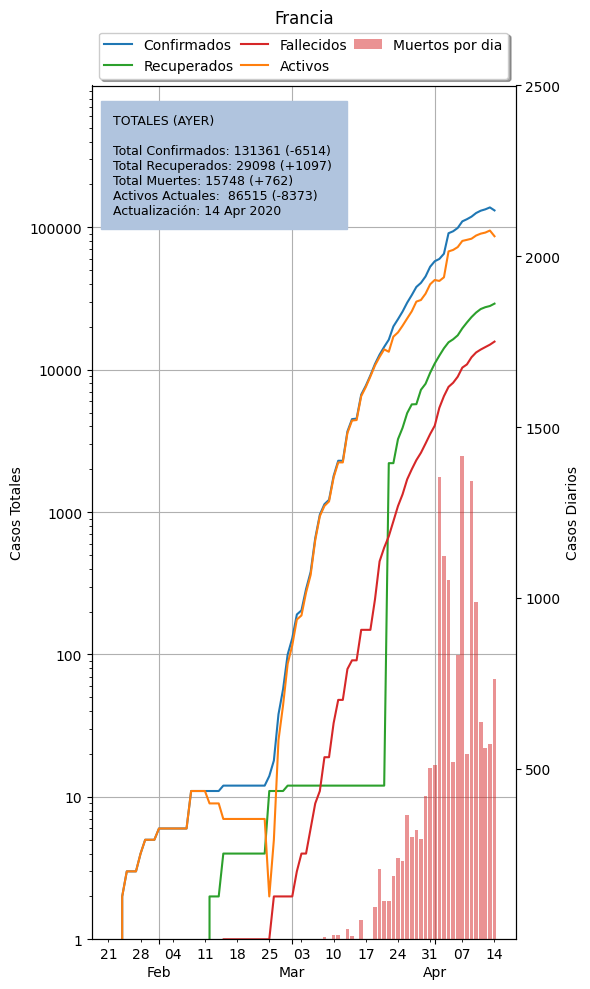

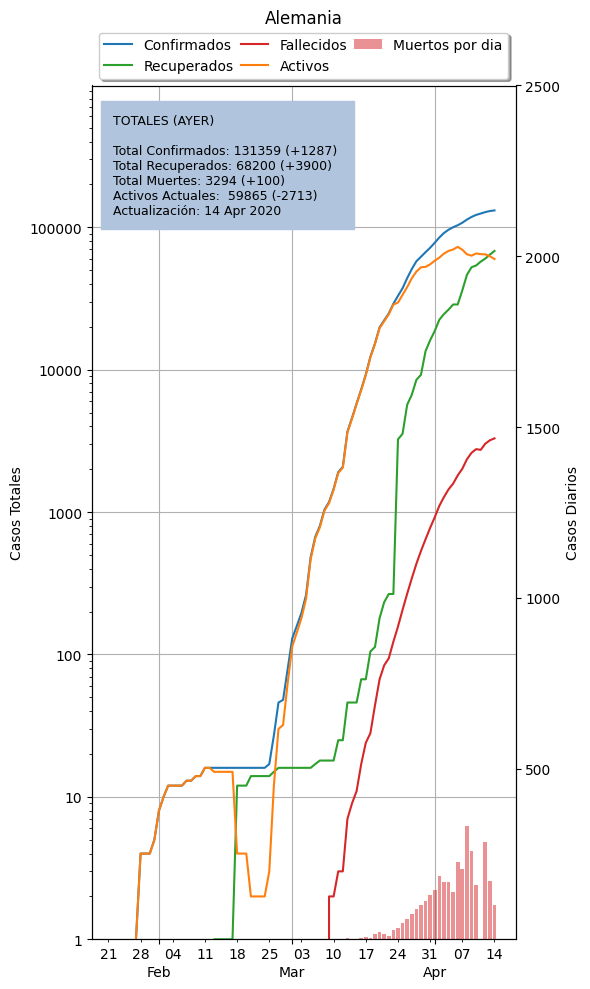

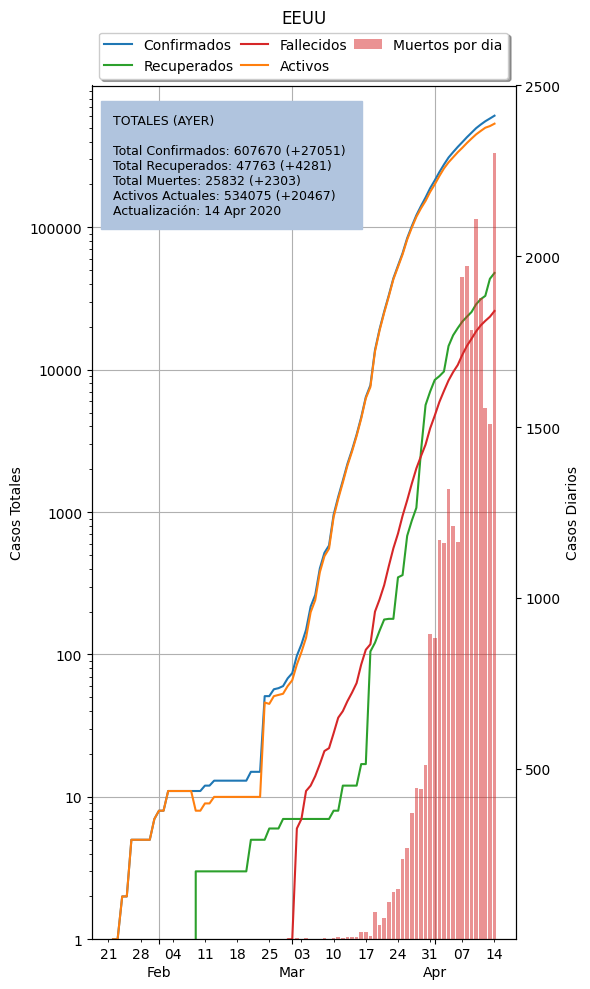

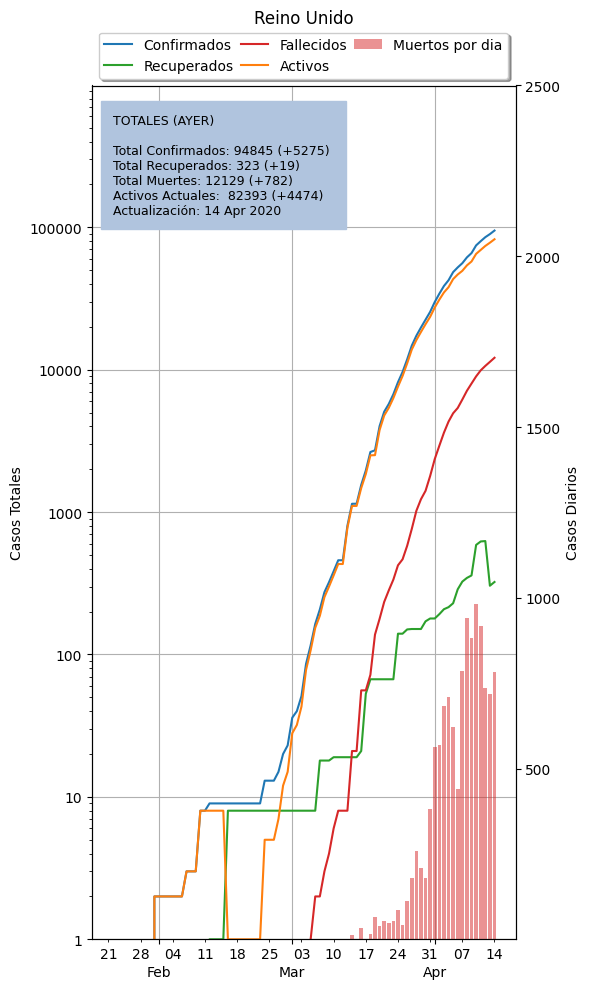

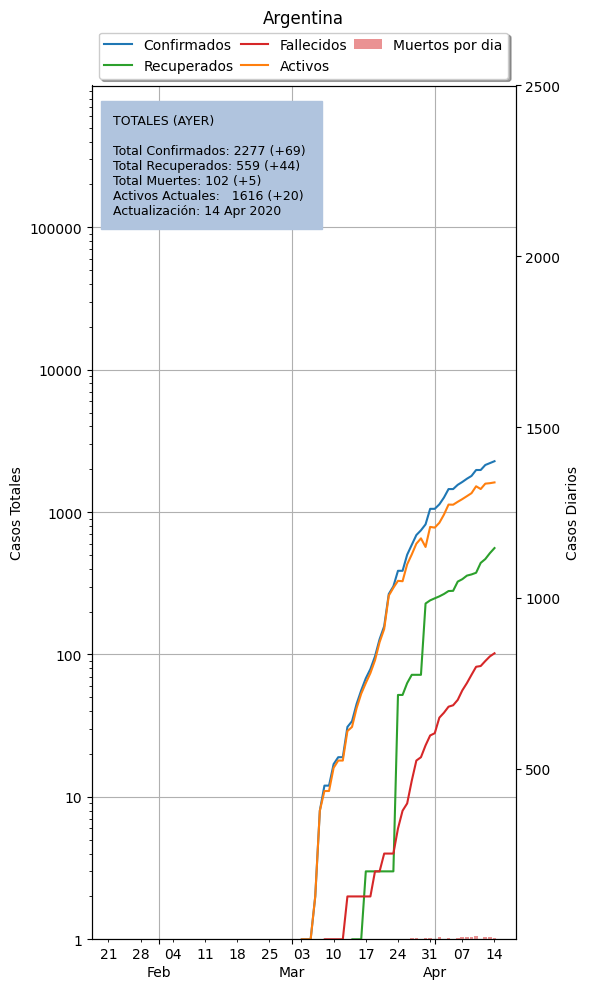

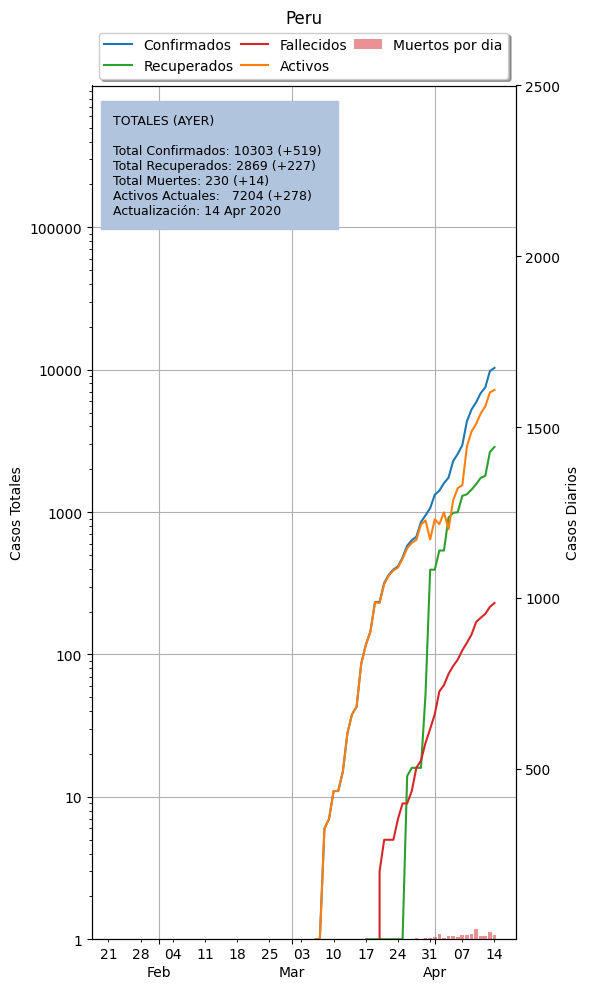

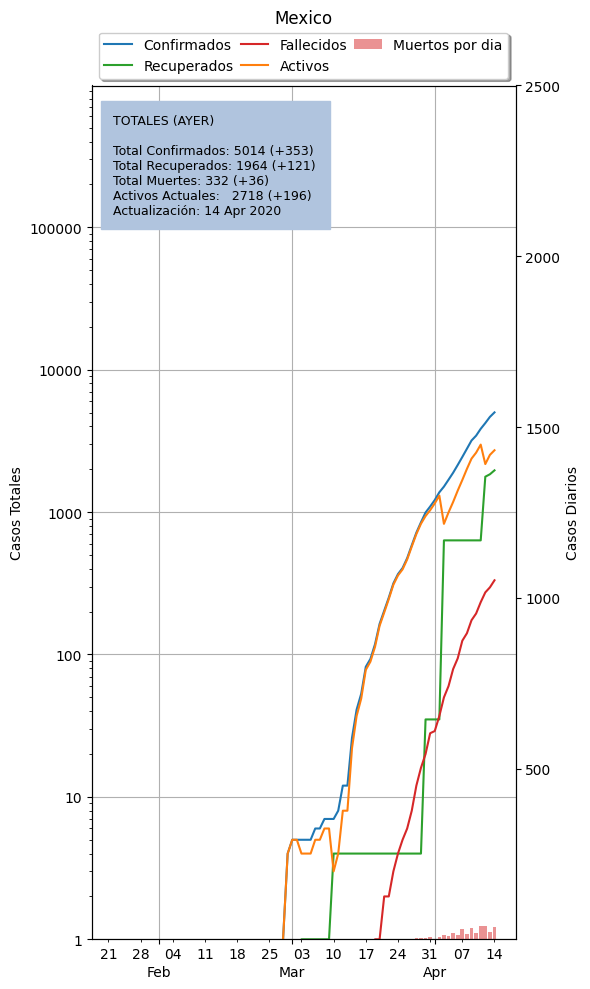

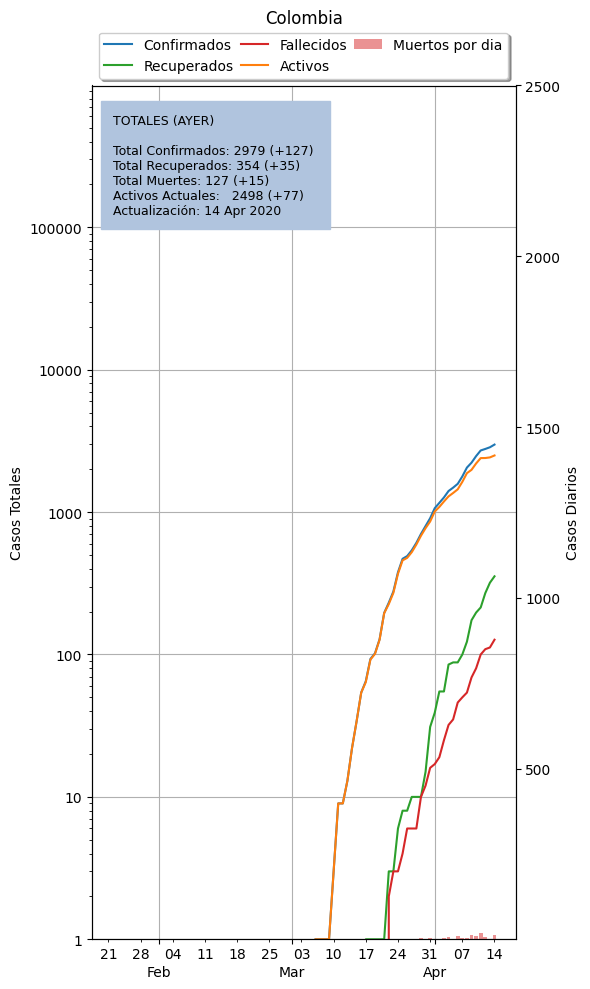

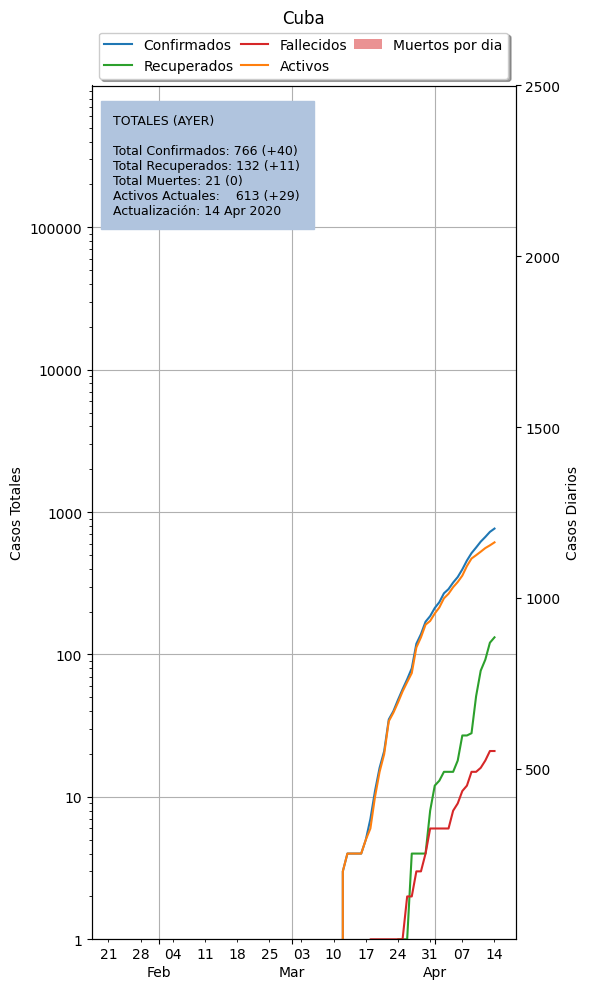

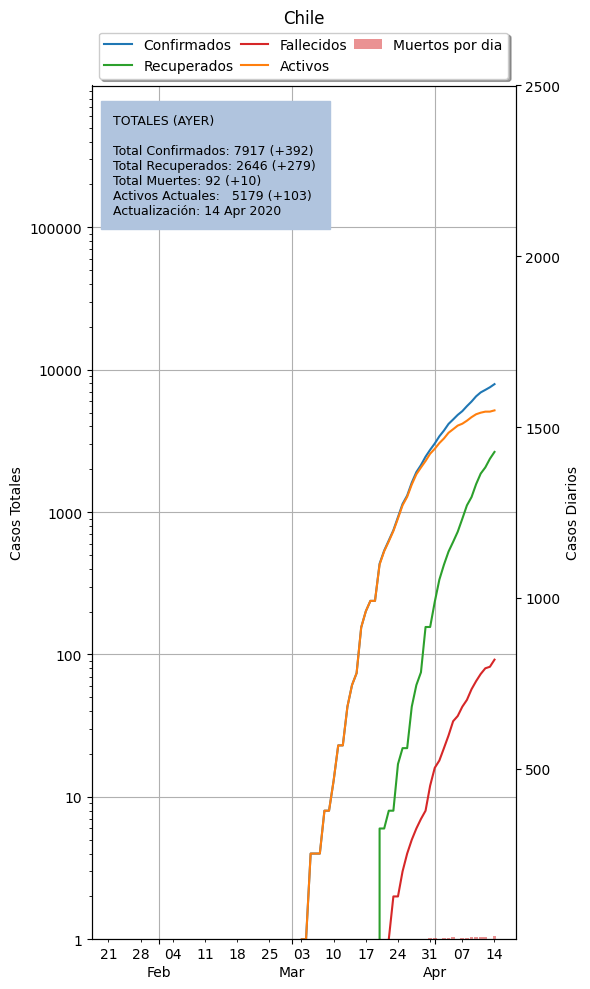

In [60]:

pais_id = 0
for country_df in data:
    fig = plt.figure(figsize=(6,10), dpi=100)
    ax = fig.add_subplot(1, 1, 1)

    #country_df[['Confirmados', 'Recuperados', 'Muertos', 'Activos']].plot(ax=ax, color=['#1F77B4','#2CA02C','#D62728','#FF7F0E'])
    ax.plot(country_df['Confirmados'], label='Confirmados', color='#1F77B4')
    ax.plot(country_df['Recuperados'], label='Recuperados', color='#2CA02C')
    ax.plot(country_df['Muertos'], label='Fallecidos', color='#D62728')
    ax.plot(country_df['Activos'], label='Activos', color='#FF7F0E')
    
    ax.set_ylabel('Casos Totales')
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())

    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    xax = ax.get_xaxis()
    xax.set_tick_params(which='major', pad=15)

    
    ax.legend(loc='best')
    ax.grid()    
    ax.text(0.05,0.85, generate_info_text(country_df), transform=ax.transAxes,
            fontsize=9,
            bbox=dict(boxstyle="square",
                      ec='lightsteelblue',
                      facecolor='lightsteelblue',
                      pad= 1
                   ))
    ax2 = ax.twinx()
    ax2.set_yscale('linear')
    ax2.set_ylim(1,2500)
    ax2.set_ylabel('Casos Diarios')
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator())
    xax2 = ax2.get_xaxis()
    xax2.set_tick_params(which='major', pad=15)
    
#    #country_df[['Muertos_por_dia']].plot(ax=ax2,linestyle='dashed', color='#D62728')
    ax2.bar(x=country_df.index, height=country_df['Muertos_por_dia'], label='Muertos por dia', color='#D62728', alpha=0.5)
##    country_df.plot.bar(y='Muertos_por_dia',color='#D62728')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fancybox=True, shadow=True, loc='lower left',mode="expand", bbox_to_anchor=(0., 1., 0.999, .102),
             ncol=3)
    
    ax2.legend().remove()
    if (titles[pais_id]=="UK"):
        title = 'Reino Unido'
    else:
        title = titles[pais_id]
            
    ax.set_title(title, pad=45)
    
    filename = titles[pais_id].replace('ñ','n')
    fig.tight_layout()
    fig.savefig(f'{filename}-test.png')
    pais_id +=1

# Comparativas


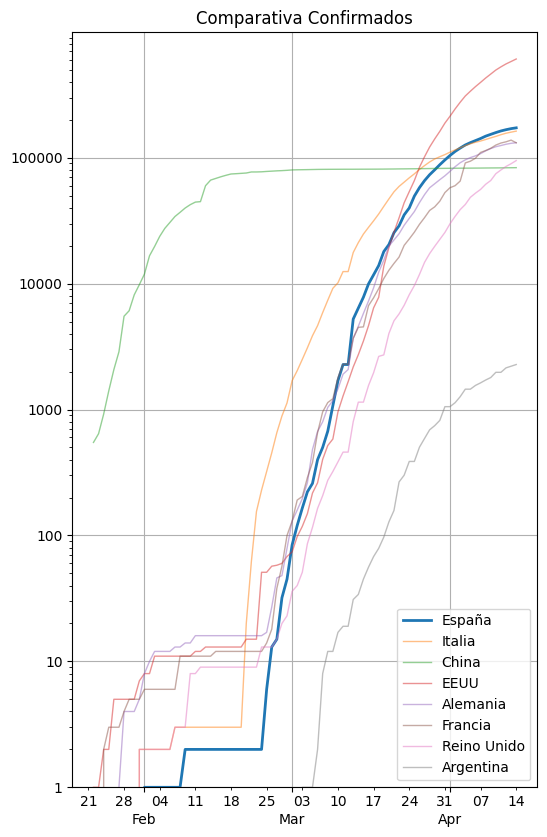

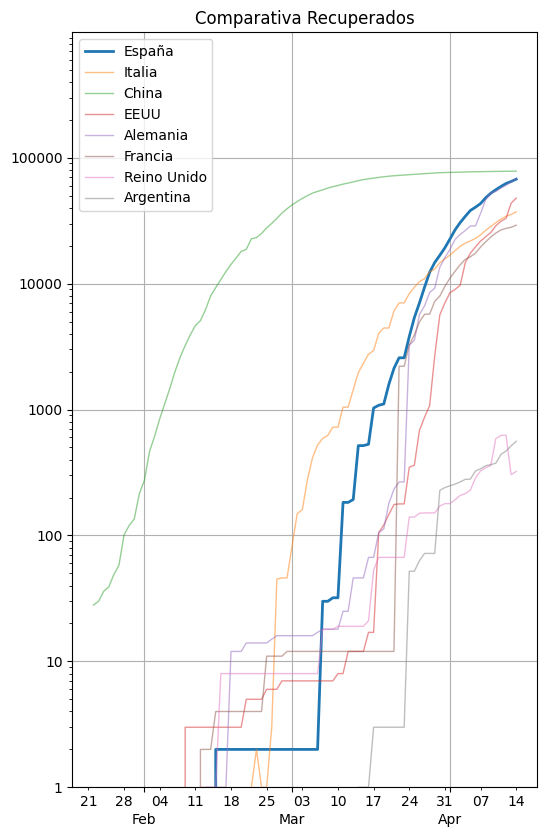

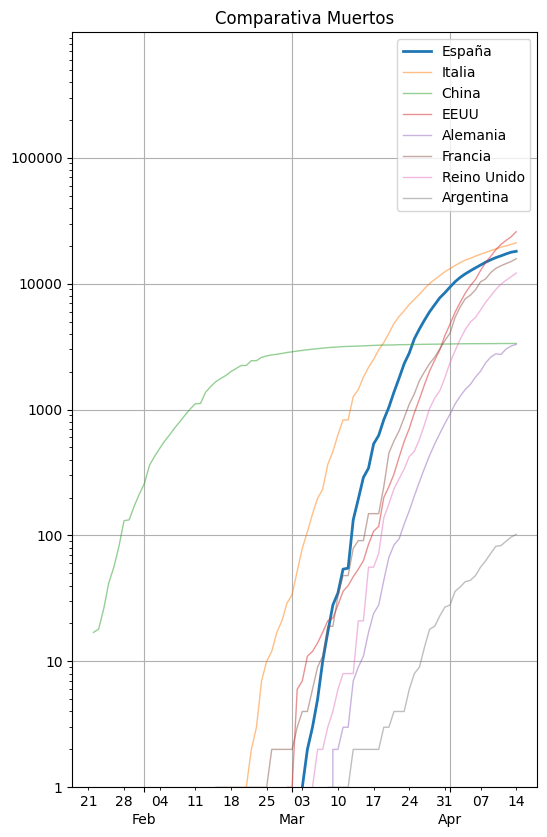

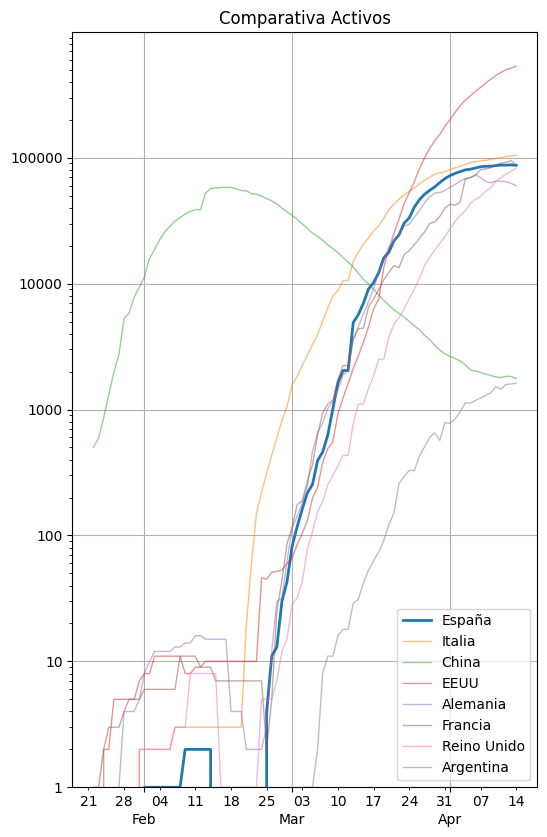

In [61]:
estados =['Confirmados', 'Recuperados', 'Muertos', 'Activos']
for estado in estados:
    fig = plt.figure(figsize=(6,10), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(spain_df[estado], label='España',linewidth=2)
    ax.plot(italia_df[estado], label='Italia',linewidth=1, alpha = 0.5)
    ax.plot(china_df[estado], label='China',linewidth=1, alpha = 0.5)
    ax.plot(eeuu_df[estado], label='EEUU',linewidth=1, alpha = 0.5)
    ax.plot(germany_df[estado], label='Alemania',linewidth=1, alpha = 0.5)
    ax.plot(francia_df[estado], label='Francia',linewidth=1, alpha = 0.5)
    ax.plot(uk_df[estado], label='Reino Unido',linewidth=1, alpha = 0.5)
    ax.plot(argentina_df[estado], label='Argentina',linewidth=1, alpha = 0.5)
    
    ax.set_title(f'Comparativa {estado}')
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())

    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    xax = ax.get_xaxis()
    xax.set_tick_params(which='major', pad=15)
    
    
    ax.legend(loc='best')
    ax.grid()    
    
    fig.savefig(f'comparativa_{str(estado)}.png')

# Animacion Confirmados

timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60
timestep 61
timestep 62
timestep 63
timestep 64
timestep 65
timestep 66
timestep 67
timestep 68
timestep 69
timestep 70
timestep 71
timestep 72
timestep 73
timestep 74
timestep 75
timestep 76
timestep 77
timestep 78
timestep 79
timestep 80
timestep 81
timestep 82
timestep 83
ti

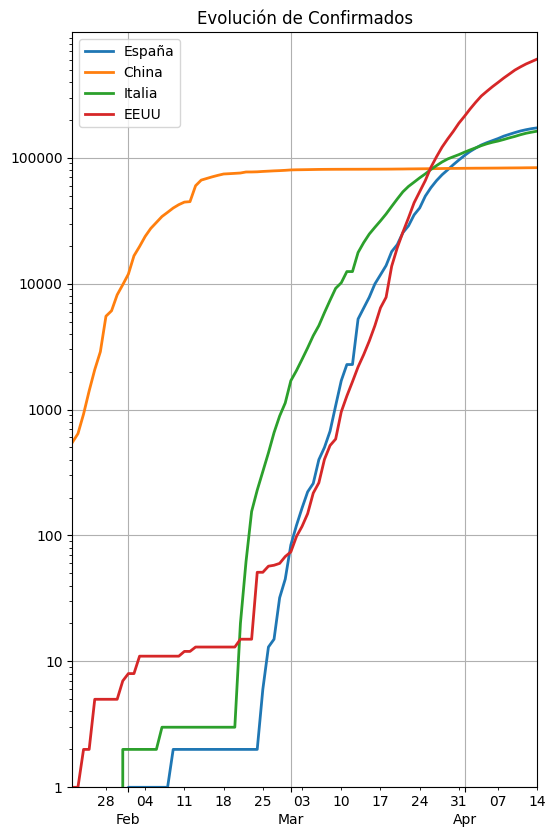

In [62]:

fig = plt.figure(figsize=(6,10), dpi=100)
ax = plt.axes(xlim=(spain_df['Confirmados'].index[0], spain_df['Confirmados'].index[-1]), ylim=(1, max_y))

#ax.plot(spain_df[estado], label='España',linewidth=2)
#ax.plot(italia_df[estado], label='Italia',linewidth=1, alpha = 0.5)
#ax.plot(china_df[estado], label='China',linewidth=1, alpha = 0.5)
#ax.plot(eeuu_df[estado], label='EEUU',linewidth=1, alpha = 0.5)
#ax.plot(germany_df[estado], label='Alemania',linewidth=1, alpha = 0.5)
#ax.plot(francia_df[estado], label='Francia',linewidth=1, alpha = 0.5)
#ax.plot(uk_df[estado], label='Reino Unido',linewidth=1, alpha = 0.5)

espana_plot, = ax.plot([], [], lw=2, label='España')
china_plot, = ax.plot([], [], lw=2, label='China')
italia_plot, = ax.plot([], [], lw=2, label='Italia')
eeuu_plot, = ax.plot([], [], lw=2, label='EEUU')

#ax.set_title(f'Comparativa')
ax.set_yscale('log')
#ax.set_ylim(1, max_y)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())


xax = ax.get_xaxis()
xax.set_tick_params(which='major', pad=15)

ax.legend(loc='upper left')
ax.grid()    

x = np.array(spain_df.index)
espana_y = np.array(spain_df['Confirmados'])
china_y = np.array(china_df['Confirmados'])
italia_y = np.array(italia_df['Confirmados'])
eeuu_y = np.array(eeuu_df['Confirmados'])

xdata, espana_ydata, china_ydata, italia_ydata, eeuu_ydata = [], [] , [], [], []
ax.set_title(f"Evolución de Confirmados")

def init():
    espana_plot.set_data([], [])
    china_plot.set_data([], [])
    italia_plot.set_data([], [])
    eeuu_plot.set_data([], [])

    
    return espana_plot,china_plot,italia_plot, eeuu_plot

def update(i):
    print(f'timestep {i}')

    xdata.append(x[i]) 
    espana_ydata.append(espana_y[i]) 
    china_ydata.append(china_y[i]) 
    italia_ydata.append(italia_y[i])
    eeuu_ydata.append(eeuu_y[i])
    
    espana_plot.set_data(xdata, espana_ydata)
    china_plot.set_data(xdata, china_ydata)
    italia_plot.set_data(xdata, italia_ydata)
    eeuu_plot.set_data(xdata, eeuu_ydata)

    return espana_plot, china_plot, italia_plot, eeuu_plot

HOLD_COUNT = 5000
def frame_generator():
    for frame in np.arange(0, spain_df.count()['Confirmados']):
        # Yield the frame first
        yield frame
        # If we should "sleep" here, yield None HOLD_COUNT times
        if frame == spain_df.count()['Confirmados']-1:
            for _ in range(HOLD_COUNT):
                yield frame

#anim = FuncAnimation(fig, update, init_func=init, frames=np.arange(0, spain_df.count()['Confirmados']-1), interval=200, repeat=True, repeat_delay = 3000)
anim = FuncAnimation(fig, update, init_func=init, frames=frame_generator, interval=150,blit=True)
anim.save("Evolucion_confirmados.gif", writer = 'imagemagick')



# Animacion muertes

timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60
timestep 61
timestep 62
timestep 63
timestep 64
timestep 65
timestep 66
timestep 67
timestep 68
timestep 69
timestep 70
timestep 71
timestep 72
timestep 73
timestep 74
timestep 75
timestep 76
timestep 77
timestep 78
timestep 79
timestep 80
timestep 81
timestep 82
timestep 83
ti

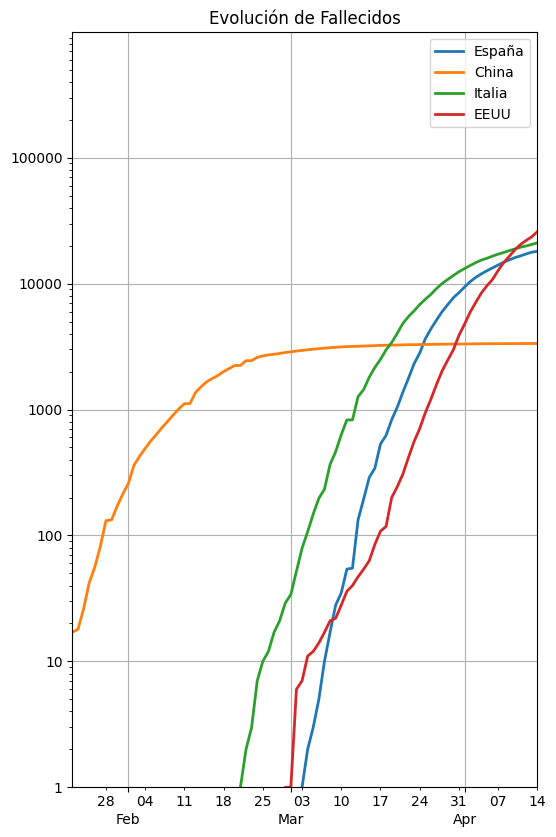

In [63]:

fig = plt.figure(figsize=(6,10), dpi=100)
ax = plt.axes(xlim=(spain_df['Muertos'].index[0], spain_df['Muertos'].index[-1]), ylim=(1, max_y))

#ax.plot(spain_df[estado], label='España',linewidth=2)
#ax.plot(italia_df[estado], label='Italia',linewidth=1, alpha = 0.5)
#ax.plot(china_df[estado], label='China',linewidth=1, alpha = 0.5)
#ax.plot(eeuu_df[estado], label='EEUU',linewidth=1, alpha = 0.5)
#ax.plot(germany_df[estado], label='Alemania',linewidth=1, alpha = 0.5)
#ax.plot(francia_df[estado], label='Francia',linewidth=1, alpha = 0.5)
#ax.plot(uk_df[estado], label='Reino Unido',linewidth=1, alpha = 0.5)

espana_plot, = ax.plot([], [], lw=2, label='España')
china_plot, = ax.plot([], [], lw=2, label='China')
italia_plot, = ax.plot([], [], lw=2, label='Italia')
eeuu_plot, = ax.plot([], [], lw=2, label='EEUU')

#ax.set_title(f'Comparativa')
ax.set_yscale('log')
#ax.set_ylim(1, max_y)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())


xax = ax.get_xaxis()
xax.set_tick_params(which='major', pad=15)

ax.legend(loc='best')
ax.grid()    

x = np.array(spain_df.index)
espana_y = np.array(spain_df['Muertos'])
china_y = np.array(china_df['Muertos'])
italia_y = np.array(italia_df['Muertos'])
eeuu_y = np.array(eeuu_df['Muertos'])

xdata, espana_ydata, china_ydata, italia_ydata, eeuu_ydata = [], [] , [], [], []
ax.set_title(f"Evolución de Fallecidos")

def init():
    espana_plot.set_data([], [])
    china_plot.set_data([], [])
    italia_plot.set_data([], [])
    eeuu_plot.set_data([], [])
    return espana_plot,china_plot,italia_plot, eeuu_plot

def update(i):
    print(f'timestep {i}')
    xdata.append(x[i]) 
    espana_ydata.append(espana_y[i]) 
    china_ydata.append(china_y[i]) 
    italia_ydata.append(italia_y[i])
    eeuu_ydata.append(eeuu_y[i])
    
    espana_plot.set_data(xdata, espana_ydata)
    china_plot.set_data(xdata, china_ydata)
    italia_plot.set_data(xdata, italia_ydata)
    eeuu_plot.set_data(xdata, eeuu_ydata)
    
    
    return espana_plot, china_plot, italia_plot, eeuu_plot

def frame_generator():
    for frame in np.arange(0, spain_df.count()['Confirmados']):
        # Yield the frame first
        yield frame
        # If we should "sleep" here, yield None HOLD_COUNT times
        if frame == spain_df.count()['Confirmados']-1:
            for _ in range(HOLD_COUNT):
                yield frame

anim = FuncAnimation(fig, update, init_func=init, frames=frame_generator, interval=150,blit=True)
anim.save("Evolucion_fallecidos.gif", writer = 'imagemagick')


# Actualizacion Repositorio

In [100]:
import git

repo = git.Repo('.')
print(repo.is_dirty())  # check the dirty state
repo.untracked_files
#print(len(repo.remotes))
#print(repo.remotes)
#print(repo.index)
#print(repo)
#print(repo.index.diff(None)) # diff with the working copy

files = repo.git.diff(None, name_only=True)
if files:
    for f in files.split('\n'):
        print(f)
        repo.git.add(f)
    
commit_message = f'Actualizacion: {datetime.today()}'
print(commit_message)
try:
    repo.git.commit('-m', commit_message)
    print(repo.heads.master)
    print(repo.remotes.origin.url)
    repo.remotes.origin.push()
#    ssh_cmd = 'ssh -i id_rsa'
#    with repo.git.custom_environment(GIT_SSH_COMMAND=ssh_cmd):
#        repo.remotes.origin.push()

except ValueError:
    print(f'Error al subir los archivos al repositorio: {ValueError}')

False
Actualizacion: 2020-04-16 00:13:58.455702


GitCommandError: Cmd('git') failed due to: exit code(1)
  cmdline: git commit -m Actualizacion: 2020-04-16 00:13:58.455702
  stdout: 'On branch master
nothing to commit, working tree clean'